In [1]:
from sklearn import datasets
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cvxpy as cvx
import numpy as np
import random

iris = datasets.load_iris()
X = iris.data 
X = X - np.mean(X , axis = 0) 
y = iris.target

def plot_3D(X_reduced,y):
    
    #To getter a better understanding of interaction of the dimensions
    # plot the first three PCA dimensions
    fig = plt.figure(1, figsize=(8, 6))
    ax = Axes3D(fig, elev=-150, azim=110)
    ax.scatter(
        X_reduced[:, 0],
        X_reduced[:, 1],
        X_reduced[:, 2],
        c=y,
        cmap=plt.cm.Set1,
        edgecolor="k",
        s=40,
    )
    ax.set_title("First three PCA directions")
    ax.set_xlabel("1st eigenvector")
    ax.w_xaxis.set_ticklabels([])
    ax.set_ylabel("2nd eigenvector")
    ax.w_yaxis.set_ticklabels([])
    ax.set_zlabel("3rd eigenvector")
    ax.w_zaxis.set_ticklabels([])

    plt.show()

/tmp/ipykernel_18521/1584760771.py:19: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, elev=-150, azim=110)


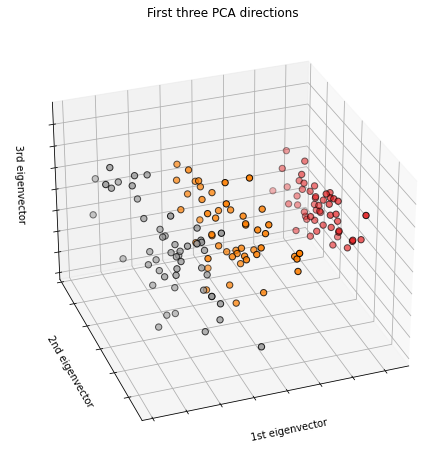

In [2]:
X_pca = PCA(n_components=3).fit_transform(X)
plot_3D(X_pca,y)

In [3]:
def project_spca(n_components,A,s):
    """  Projects matrix A into the subspace spanned by the DSCPA.
    
    Returns:
        ndarray: Matrix A projected into the DSCPA direction.
    """
    
    C = np.cov(A,rowvar=False)     
    spca = compute_pca_directions(C,n_components,s)
    A_reduced =  A @ spca
    
    return A_reduced
    
    
def compute_pca_directions(C,n_components,s):
    
    """Compute n_components of DSCPA decomposition.
    Each component spans at most k dimensions.
    
    Args:
        n_components (int): number of computed directions.
        C (ndarray): Covariance matrix : MUST BY SYMMETRICAL !!
        s (int): number of components in each direction

    Returns:
        ndarray: the directions of PCA
    """
    
    rslt = np.zeros((C.shape[0],n_components))
    
    for i in range(n_components):
        
        value,sol = solve_sdp(C,s)
        eigvals,eigvecs = np.linalg.eigh(sol)
        x = eigvecs[0].reshape(-1,1)  ## x such that  X = x@x.T
        rslt[:,i] = x.squeeze()
        
        C = C - value * sol ##A_2 
        
        print("x has ",np.sum(x>1e-2) ,"sparse components")
        print("Sum ABS X =",np.sum(np.abs(sol)),"Rank X =",np.linalg.matrix_rank(sol))

        
    return rslt
 
def solve_sdp(C, s):
    
    """Compute a solution the s-sparse PCA of A.

    Args:
        A (ndarray): Matrix to extract the sub-matrix from
        s (int): Sparsity level for the lower bound.

    Returns:
        (int,ndarray): value and optimal point
    """
    ro = 0.6
    n_dim = C.shape[0]
    X = cvx.Variable((n_dim, n_dim),symmetric=True)
    
    pb = cvx.Problem(cvx.Maximize(cvx.trace(C@X)),
                     [cvx.constraints.PSD(X),
                      cvx.constraints.Zero(cvx.trace(X) - 1),
                      cvx.constraints.NonPos(cvx.sum(cvx.abs(X)) - s)
                      ])
    
    # pb = cvx.Problem(cvx.Maximize(cvx.trace(C@X)- ro*cvx.sum(cvx.abs(X))),
    #                             [cvx.constraints.PSD(X),
    #                             cvx.constraints.Zero(cvx.trace(X) - 1)
    #                             ])
                     
    pb.solve(verbose=False, max_iters=100000)
    
    return pb.value,X.value
    
        

x has  2 sparse components
Sum ABS X = 2.7584818734348255 Rank X = 4
x has  1 sparse components
Sum ABS X = 2.675211403189154 Rank X = 4
x has  3 sparse components
Sum ABS X = 2.99999909549452 Rank X = 4


/tmp/ipykernel_18521/1584760771.py:19: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, elev=-150, azim=110)


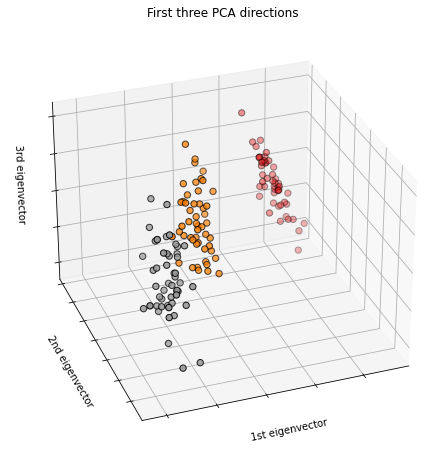

In [4]:
#X_rand = np.random.rand(100,5)
X_spca = project_spca(n_components=3,A=X,s=3)
plot_3D(X_spca,y)

In [11]:
n,k,p = 50,5,0.5

def PlantedClique(k,p,n):
    
    bernoullis = random.choices([0, 1],weights=[1-p,p], k=n*n)
    Adj = np.array(bernoullis).reshape((n, n))
    Adj[:k,:k] = 1 ## plant clique
    Adj = 1 * ((Adj + Adj.T)>=1) ## symmetrize matrix
    #np.random.shuffle(Adj)
    
    return Adj

Adj = PlantedClique(k,p,n)
B = Adj - p * np.ones_like(Adj)

x has  14 sparse components
Sum ABS X = 5.000010509646046 Rank X = 50


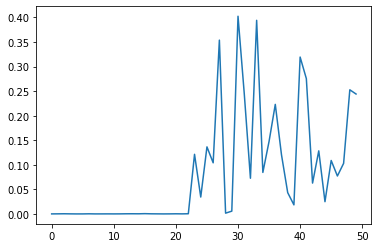

In [12]:
x = compute_pca_directions(B,n_components=1,s=k)
plt.plot(abs(x))